# SanityChecker: 

### Patch Clamp Electrophysiology Notebook that implements low level methods from PatchAnalyzer to do patch analysis without a GUI.



In [47]:
# ------------------------------------------------------------------
# Make the *outer* repo folder importable
# ------------------------------------------------------------------
import sys
from pathlib import Path
import pandas as pd

nb_path   = Path.cwd()                 # e.g. …/ProjectRoot/PatchAnalyzer/AnalysisTesting
repo_root = nb_path.parents[1]         # go up two levels → …/ProjectRoot/

if str(repo_root) not in sys.path:
    sys.path.insert(0, str(repo_root))

# sanity check (optional)
# print("repo root on sys.path:", repo_root)


In [48]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ipywidgets as W
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt


# ------------------------------------------------------------------
# PatchAnalyzer helpers
# ------------------------------------------------------------------
from PatchAnalyzer.models.data_loader import load_metadata
from PatchAnalyzer.models.ephys_loader import (
    load_voltage_traces_for_indices,
    load_current_traces,          # nested CC helper
)
from PatchAnalyzer.utils.passives import (
    compute_passive_params,       # VC
    compute_cc_passive_params,    # CC
)
from PatchAnalyzer.utils.spike_params import (
    Sweep,
    calc_firing_curve,
    calc_spike_metrics,
)

plt.rcParams["figure.dpi"] = 110


In [49]:
# Select multiple experiment dirs the same way the GUI’s WelcomePage does
exp_dirs = [
    # Path(r"C:\Users\sa-forest\Documents\GitHub\PatchAnalyzer\Data\Test\2025_06_25-12_09"),   # TODO – add as many as you like
    # Path(r"C:\Users\sa-forest\Documents\GitHub\PatchAnalyzer\Data\Test\2025_06_25-13_07"),
    # Path(r"C:\Users\sa-forest\Documents\GitHub\PatchAnalyzer\Data\Test\2025_06_25-13_30"),
    Path(r"C:\Users\sa-forest\Documents\GitHub\PatchAnalyzer\Data\Test\2025_06_25-15_58"),
    
    # Path("/path/to/another/experiment"),
]
exp_dirs


[WindowsPath('C:/Users/sa-forest/Documents/GitHub/PatchAnalyzer/Data/Test/2025_06_25-15_58')]

In [50]:
# ---------------------------------------------------------------------------
# Build `cells`  →  key = (exp_dir, (x,y,z))
#                   val = {"vc": [...], "cc": {cell_id: {current: trace}} }
# ---------------------------------------------------------------------------
cells = {}

meta_frames = []
for exp in exp_dirs:
    try:
        meta_frames.append(load_metadata([exp]))
    except ValueError:
        print(f"⚠  No CellMetadata in {exp}")

if not meta_frames:
    raise RuntimeError("No cell metadata loaded – check folder paths.")

meta_df = pd.concat(meta_frames, ignore_index=True)

idx_col = "indices" if "indices" in meta_df.columns else "index"
if idx_col not in meta_df.columns:
    raise RuntimeError("Neither “indices” nor “index” column found in metadata")

for coord, sub in meta_df.groupby(["stage_x", "stage_y", "stage_z"]):
    exp_dir       = Path(sub["src_dir"].iloc[0])
    sweep_indices = sub[idx_col].tolist()        # list[int]  → cell numbers

    # --- Voltage-clamp
    vc_traces = [
        (t, cmd, rsp)
        for idx in sweep_indices
        for (t, cmd, rsp) in load_voltage_traces_for_indices(exp_dir, [idx]).values()
    ]

    # --- Current-clamp   nested {cell_id ▶ current ▶ trace}
    cc_nested = load_current_traces(exp_dir, sweep_indices)

    cells[(exp_dir, coord)] = dict(vc=vc_traces, cc=cc_nested)

print(f"Found {len(cells)} unique physical cells")


2025-07-14 18:32:09,738 [INFO] Loaded 6 rows from C:\Users\sa-forest\Documents\GitHub\PatchAnalyzer\Data\Test\2025_06_25-15_58\CellMetadata\cell_metadata.csv
Found 2 unique physical cells


In [51]:
for (exp, coord), d in cells.items():
    n_vc = len(d['vc'])
    n_cc = sum(len(cur_dict) for cur_dict in d['cc'].values())
    print(f"{exp.name} {coord}: {n_vc} VC traces, {n_cc} CC traces")
    for cid, cur_dict in d['cc'].items():
        print(f"    cell {cid}: {len(cur_dict)} CC sweeps")



2025_06_25-15_58 (np.float64(2191.924664667212), np.float64(48866.046024274525), np.float64(20327.8)): 5 VC traces, 151 CC traces
    cell 2: 23 CC sweeps
    cell 3: 25 CC sweeps
    cell 4: 33 CC sweeps
    cell 5: 35 CC sweeps
    cell 6: 35 CC sweeps
2025_06_25-15_58 (np.float64(2906.2965543591563), np.float64(45936.06428926166), np.float64(20372.9)): 1 VC traces, 5 CC traces
    cell 1: 5 CC sweeps


In [52]:
# ---------- choose the physical cell & recorder cell-number -------------
exp_dir   = exp_dirs[0]          # one experiment          (dropdown if you like)
cell_id   = 5                   # the *CurrentProtocol_* <cell_id>  you want
test_amp  = -20                  # pA – amplitude of the test pulse


In [53]:
# ────────── VC passive extraction for this physical cell ──────────
from PatchAnalyzer.utils.passives import compute_passive_params
import numpy as np

# locate the (exp_dir, coord) key that matches this experiment
coord_key = next(k for k in cells if k[0] == exp_dir)
data      = cells[coord_key]

vc_traces = data["vc"]                    # list of (t, cmd, rsp)
vc_outs   = [compute_passive_params(*tr) for tr in vc_traces]
vc_valid  = [o for o in vc_outs if all(v is not None for v in o)]

if vc_valid:
    Ra_mohm, Rm_mohm, Cm_pf = map(np.mean, zip(*vc_valid))
    print(f"Voltage‑clamp (mean of {len(vc_valid)} fits):")
    print(f"  Ra = {Ra_mohm:.1f} MΩ   Rm = {Rm_mohm:.1f} MΩ   Cm = {Cm_pf:.1f} pF")
else:
    Ra_mohm = Rm_mohm = Cm_pf = np.nan
    print("No successful VC passive fits.")

# keep these three variables for later comparison if you wish


Voltage‑clamp (mean of 5 fits):
  Ra = 36.3 MΩ   Rm = 48.1 MΩ   Cm = 139.3 pF


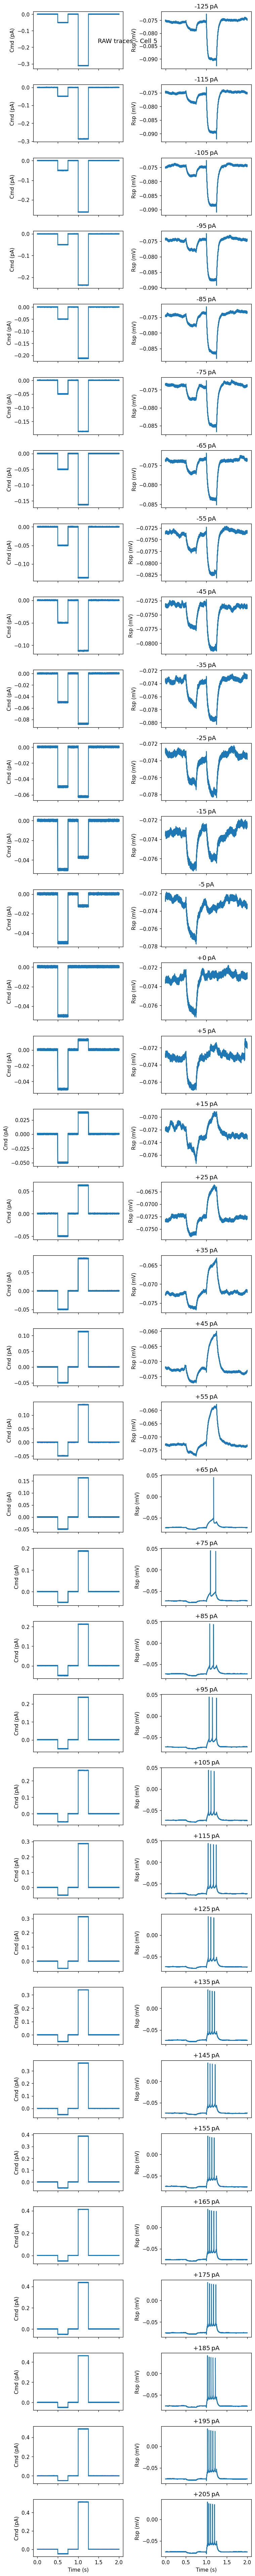

In [54]:
# ----------- gather sweeps for *one* (exp_dir, coord) --------------------
key     = coord_key                    # re‑use variable from the VC cell
cc_dict = cells[key]["cc"]             # {cell_id: {current: trace}}
sweeps  = cc_dict.get(cell_id, {})     # all sweeps for this cell_id
if not sweeps:
    raise RuntimeError(f"No CC sweeps found for cell {cell_id}")

# ---------- plot *entire* command/response for every sweep ---------------
fig, axs = plt.subplots(len(sweeps), 2,
                        figsize=(7, 2*len(sweeps)), sharex='col')
for (I, (t, cmd, rsp)), ax in zip(sorted(sweeps.items()), axs):
    ax[0].plot(t, cmd);  ax[0].set_ylabel("Cmd (pA)")
    ax[1].plot(t, rsp);  ax[1].set_ylabel("Rsp (mV)")
    ax[1].set_title(f"{I:+.0f} pA")
for a in axs[-1]:
    a.set_xlabel("Time (s)")
plt.suptitle(f"RAW traces – Cell {cell_id}"); plt.tight_layout(); plt.show()


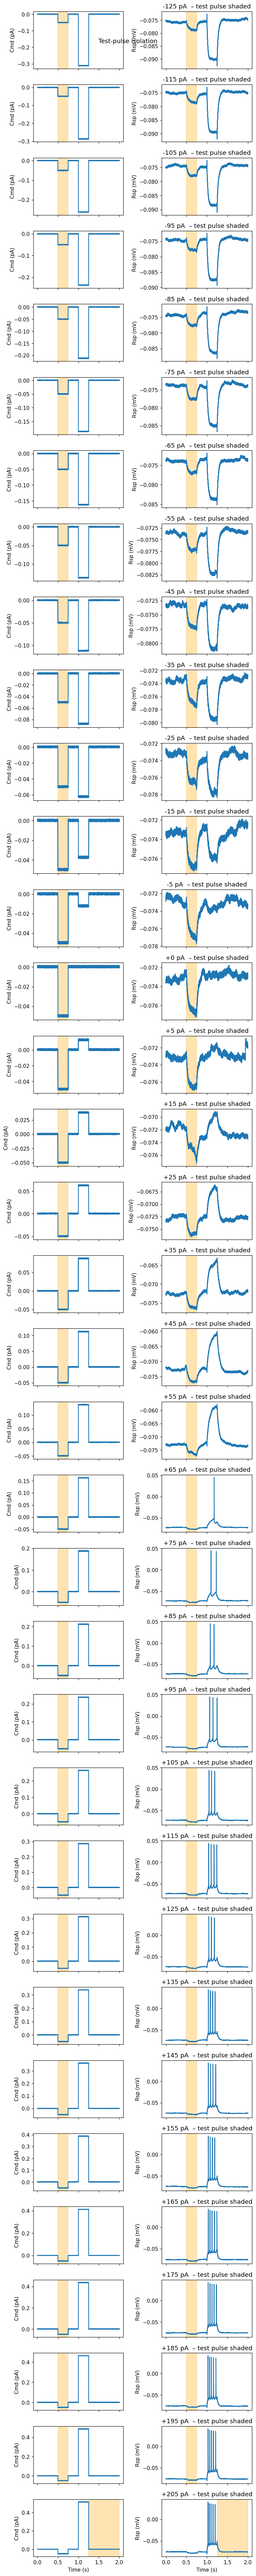

In [55]:
# helper --------------------------------------------------------------
def find_test_pulse(cmd, edge_frac=0.10, min_sep_pts=5):
    """
    Locate the first current pulse via dCmd/dt:

        • negative slope   →  start
        • positive slope   →  end   (if absent, pulse assumed till trace end)

    Parameters
    ----------
    cmd : 1‑D array (pA)
    edge_frac : float
        Fraction of the *maximum absolute* derivative used as threshold.
        0.10 ⇒ edges with |dI/dt| ≥ 10 % of the largest slope are considered.
    min_sep_pts : int
        Minimum distance (samples) between the start and end edges to avoid
        catching noise.
    Returns
    -------
    (s, e) : tuple[int, int]   indices in *cmd*
             or (None, None) if no downward edge found.
    """
    cmd = np.asarray(cmd)
    d   = np.diff(cmd, prepend=cmd[0])

    thr = edge_frac * np.max(np.abs(d))
    starts = np.where(d < -thr)[0]
    if starts.size == 0:
        return None, None       # no clear downward edge

    s = int(starts[0])

    ends = np.where((np.arange(len(d)) > s + min_sep_pts) & (d > thr))[0]
    e = int(ends[0]) if ends.size else len(cmd) - 1   # fall back to last point
    return s, e



# truncate & visualise -------------------------------------------------
trunc_sweeps = {}      # {I: (t, cmd, rsp, s, e)}
for I, (t, cmd, rsp) in sweeps.items():
    s, e = find_test_pulse(cmd)
    if s is not None and e is not None:
        trunc_sweeps[I] = (t, cmd, rsp, s, e)
    else:
        print(f"⚠  no test pulse detected in sweep {I:+.0f} pA – skipped")

if not trunc_sweeps:
    raise RuntimeError("No sweeps contained a detectable test pulse.")

fig, axs = plt.subplots(len(trunc_sweeps), 2,
                        figsize=(7, 2*len(trunc_sweeps)), sharex='col')
for (I, (t, cmd, rsp, s, e)), ax in zip(sorted(trunc_sweeps.items()), axs):
    ax[0].plot(t, cmd); ax[0].axvspan(t[s], t[e], color='orange', alpha=.3)
    ax[0].set_ylabel("Cmd (pA)")
    ax[1].plot(t, rsp); ax[1].axvspan(t[s], t[e], color='orange', alpha=.3)
    ax[1].set_ylabel("Rsp (mV)")
    ax[1].set_title(f"{I:+.0f} pA  – test pulse shaded")
for a in axs[-1]:
    a.set_xlabel("Time (s)")
plt.suptitle("Test‑pulse isolation"); plt.tight_layout(); plt.show()



C:\Users\sa-forest\AppData\Local\Temp\ipykernel_38944\3538144691.py:13: RuntimeWarning: overflow encountered in exp
  return m * np.exp(-tau_inv * t) + b


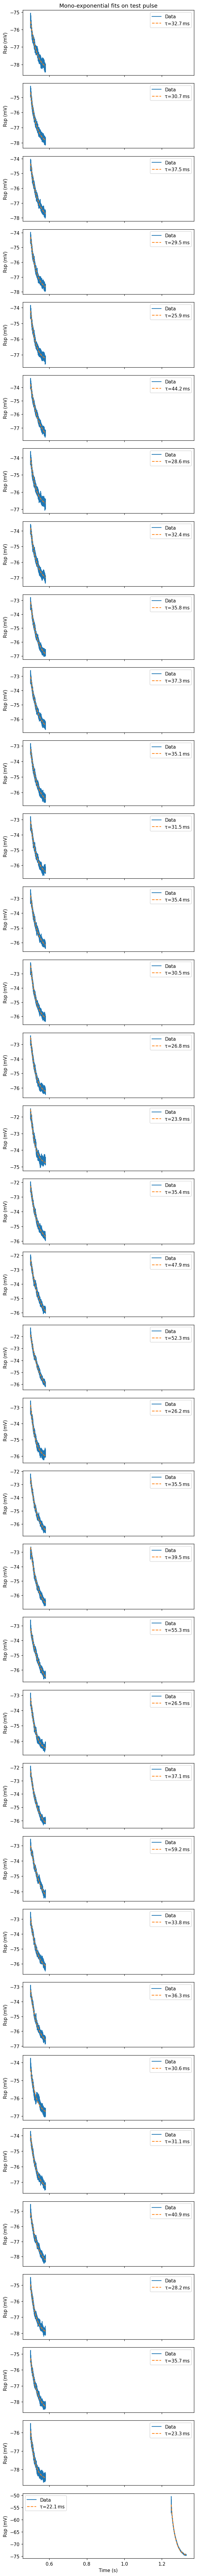

In [56]:
# --------------------------------------------------------------------------
#  Accurate passive extraction  (volts ➜ millivolts conversion)
# --------------------------------------------------------------------------
from scipy.optimize import curve_fit
import numpy as np
import matplotlib.pyplot as plt

BASELINE_MS   = 20             # ms
PLATEAU_MS    = 20             # ms
FIT_WINDOW_MS = 80             # ms

def mono_exp(t, m, tau_inv, b):          # t in ms, returns mV
    return m * np.exp(-tau_inv * t) + b

fit_results = []

fig, axs = plt.subplots(len(trunc_sweeps), 1,
                        figsize=(6, 2.2*len(trunc_sweeps)), sharex=True)

for (I, (t, cmd, rsp, s, e)), ax in zip(sorted(trunc_sweeps.items()), axs):
    dt       = t[1] - t[0]
    pre_pts  = int(BASELINE_MS   / 1000 / dt)
    plat_pts = int(PLATEAU_MS    / 1000 / dt)
    fit_pts  = int(FIT_WINDOW_MS / 1000 / dt)

    # ------------------------ volt ➜ mV ---------------------------------
    rsp_mV = rsp * 1000.0

    V_base = np.mean(rsp_mV[max(0, s-pre_pts): s])
    V_plat = np.mean(rsp_mV[max(s, e-plat_pts): e])
    dV_mV  = V_plat - V_base                  # ≈ 1–3 mV

    I_base_pA = np.mean(cmd[max(0, s-pre_pts): s])          # already pA
    I_plat_pA = np.mean(cmd[max(s, e-plat_pts): e])         # already pA
    dI_pA     = I_plat_pA - I_base_pA


    Rin_MΩ = abs(dV_mV / dI_pA)                           # mV / pA  →  MΩ

    Xfit_ms = (t[s:s+fit_pts] - t[s]) * 1000  # ms from onset
    Yfit_mV = rsp_mV[s:s+fit_pts] - V_plat    # decays to 0 mV

    try:
        p, _ = curve_fit(mono_exp, Xfit_ms, Yfit_mV,
                         p0=(Yfit_mV[0], 10, 0), maxfev=20000)
        tau_ms = 1 / p[1]
        Cm_pF  = (tau_ms / Rin_MΩ) * 1000.0    # ms / MΩ → pF


        # --------------------- plot overlay -----------------------------
        ax.plot(t[s:s+fit_pts], Yfit_mV + V_plat, label="Data")
        ax.plot(t[s:s+fit_pts],
                mono_exp(Xfit_ms, *p) + V_plat, "--",
                label=f"τ={tau_ms:.1f} ms")
        ax.set_ylabel("Rsp (mV)"); ax.legend()

        fit_results.append(dict(
            current_pA = I,
            Rin_MOhm   = Rin_MΩ,
            tau_ms     = tau_ms,
            Cm_pF      = Cm_pF,
            Rest_mV    = V_base,     # resting potential
        ))
    except RuntimeError:
        ax.plot(t[s:s+fit_pts], Yfit_mV + V_plat, 'r', label="Fit failed")
        ax.legend()

axs[-1].set_xlabel("Time (s)")
axs[0].set_title("Mono‑exponential fits on test pulse")
plt.tight_layout(); plt.show()



In [57]:
# --------------------------------------------------------------------------
#  Summary table  (one row per sweep + MEAN)
# --------------------------------------------------------------------------
res_df = pd.DataFrame(fit_results)          # columns: current_pA, Rin_MOhm, tau_ms, Cm_pF

if not res_df.empty:
    mean_row = res_df.mean(numeric_only=True).to_dict()
    mean_row["current_pA"] = "MEAN"
    res_df = pd.concat([res_df, pd.DataFrame([mean_row])], ignore_index=True)

display(res_df)

# If you ran the VC‑Rm comparison in Cell E, the printout is already there.



current_pA   Rin_MOhm     tau_ms       Cm_pF    Rest_mV
0      -125.0  61.614889  32.721376  531.062802 -75.683542
1      -115.0  78.915293  30.652653  388.424755 -74.789189
2      -105.0  67.337967  37.468434  556.423594 -74.532818
3       -95.0  67.870491  29.485536  434.438228 -74.632893
4       -85.0  62.345467  25.876692  415.053295 -74.406972
5       -75.0  72.070681  44.202610  613.323050 -73.841556
6       -65.0  50.339754  28.618306  568.503092 -74.205511
7       -55.0  63.178520  32.441967  513.496785 -74.021513
8       -45.0  79.851110  35.821308  448.601248 -73.363353
9       -35.0  81.889386  37.274779  455.184495 -73.204038
10      -25.0  69.354858  35.104765  506.161593 -73.313076
11      -15.0  65.310847  31.481028  482.018362 -73.403294
12       -5.0  81.037894  35.351503  436.234226 -73.149718
13        0.0  81.078524  30.479044  375.920058 -72.615376
14        5.0  72.116731  26.783644  371.392932 -72.832334
15       15.0  93.925890  23.947015  254.956489 -71.932022
16       25.0  66.768997  35.440370  530.790811 -72.460677
17       35.0  80.397241  47.910826  595.926241 -72.311746
18       45.0  96.556813  52.336768  542.030813 -71.668062
19       55.0  72.737116  26.209814  360.336174 -73.152402
20       65.0  83.293972  35.495704  426.149740 -72.842910
21       75.0  69.745965  39.461760  565.792726 -73.167404
22       85.0  76.789564  55.276300  719.841304 -73.221772
23       95.0  72.586844  26.505532  365.156143 -73.533884
24      105.0  91.462130  37.122233  405.875449 -72.391723
25      115.0  74.865285  59.156071  790.166902 -72.841696
26      125.0  81.528079  33.832801  414.983417 -73.082394
27      135.0  66.327388  36.344648  547.958387 -73.386008
28      145.0  71.751379  30.617096  426.710907 -74.190781
29      155.0  58.956428  31.087258  527.292086 -74.349682
30      165.0  67.551281  40.913901  605.671730 -75.068551
31      175.0  58.699363  28.223887  480.821020 -75.026884
32      185.0  62.295156  35.675731  572.688678 -75.238970
33      195.0  53.098188  23.301086  438.830153 -75.908871
34      205.0  37.001683  22.129412  598.065012 -56.910029
35       MEAN  71.161462  34.707196  493.322363 -73.162333

### 2 Active Spike Parameters calculation


Cell 5: 35 Sweep objects constructed


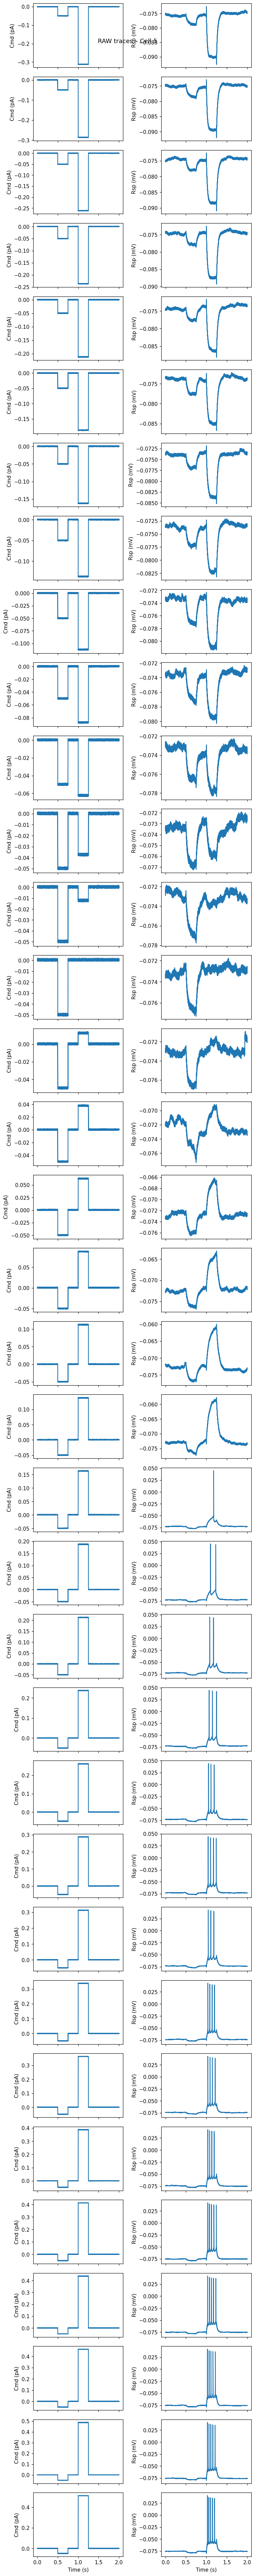

In [58]:
# %% 🔧  USER‑TUNABLE GLOBALS  🔧 ------------------------------------------------
EDGE_FRAC          = 0.15   # fraction of max |dI/dt| that counts as an edge
MIN_SEP_PTS        = 5      # min pts between start/end edges
SMOOTH_PTS         = 50     # box‑car points for spike detection
PEAK_PROMINENCE_MV = 12     # min spike prominence (mV)
DVDT_THRESH_MV_MS  = 50     # dv/dt threshold for spike threshold detection
HW_WINDOW_MS       = 3.0    # ± window for half‑width & dv/dt max (ms)
DO_NORMALISE       = True  # add NormFreq column in step‑7?

# %% 🛠️  BUILD Sweep OBJECTS  (***ONLY the chosen cell***) ----------------------
from PatchAnalyzer.utils.spike_params import Sweep

# coord_key was already defined when you ran the passive section.
# Make sure exp_dir and cell_id are still set to the cell you want.
coord_key = next(k for k in cells if k[0] == exp_dir)
cc_dict   = cells[coord_key]["cc"].get(cell_id, {})

all_sweeps: list[Sweep] = []
for (t, cmd, rsp) in cc_dict.values():
    sr = 1.0 / (t[1] - t[0])
    all_sweeps.append(
        Sweep(time=t,
              response_mV=rsp,
              command_pA=cmd,
              sample_rate=sr)
    )

print(f"Cell {cell_id}: {len(all_sweeps)} Sweep objects constructed")

# -------- plot raw traces (cmd & rsp) ----------------------------------------
fig, axs = plt.subplots(len(all_sweeps), 2,
                        figsize=(7, 2*len(all_sweeps)), sharex='col')
for sw, ax in zip(all_sweeps, axs):
    ax[0].plot(sw.time, sw.command_pA); ax[0].set_ylabel("Cmd (pA)")
    ax[1].plot(sw.time, sw.response_mV); ax[1].set_ylabel("Rsp (mV)")
axs[-1][0].set_xlabel("Time (s)"); axs[-1][1].set_xlabel("Time (s)")
plt.suptitle(f"RAW traces – Cell {cell_id}"); plt.tight_layout(); plt.show()


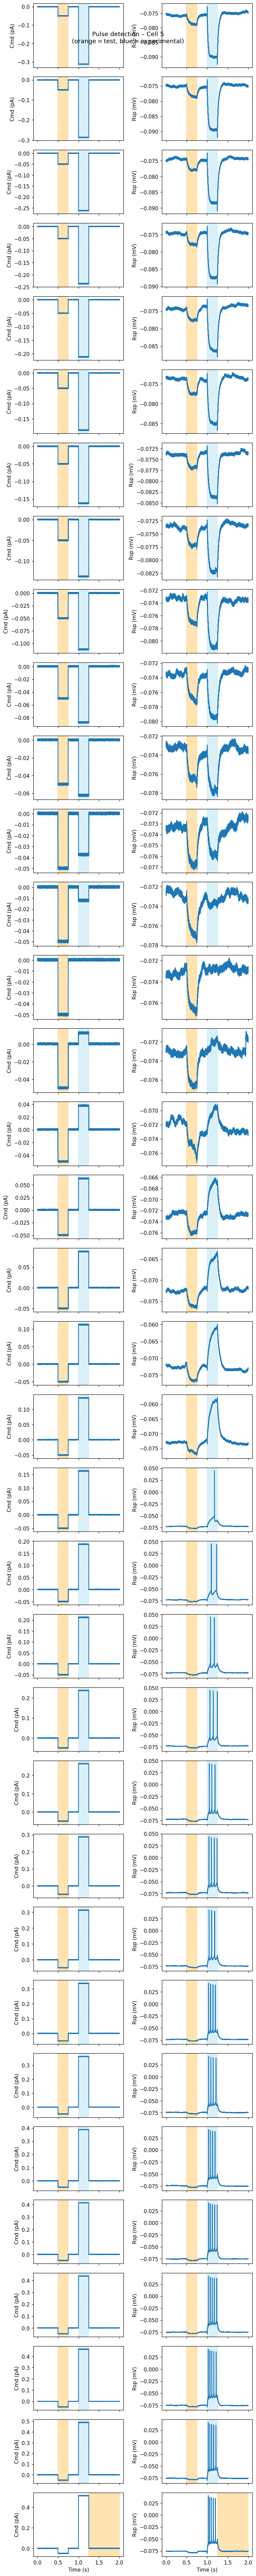

In [59]:
# %% STEP 2 – robust pulse finder  --------------------------------------------
def find_test_pulse(cmd, edge_frac=0.10, min_sep_pts=5):
    d = np.diff(cmd, prepend=cmd[0])
    thr = edge_frac * np.max(np.abs(d))
    starts = np.where(d < -thr)[0]
    if starts.size == 0:
        return None, None
    s = int(starts[0])
    ends = np.where((np.arange(len(d)) > s + min_sep_pts) & (d > thr))[0]
    e = int(ends[0]) if ends.size else len(cmd)-1
    return s, e

def find_experimental_pulse(cmd, after_idx, tol_pA=0.01):
    """
    Find the FIRST region *after* `after_idx` where |cmd - baseline| > tol_pA
    (baseline = median before test pulse). Returns (start, end).
    Works for either depolarising (+pA) or hyperpolarising (–pA) steps.
    """
    baseline = np.median(cmd[:after_idx//2]) if after_idx > 10 else np.median(cmd)
    idxs = np.where(np.abs(cmd - baseline) > tol_pA)[0]
    idxs = idxs[idxs > after_idx]
    if idxs.size == 0:
        return None, None
    s = int(idxs[0])
    ends = np.where((np.abs(cmd - baseline) <= tol_pA) & (np.arange(len(cmd)) > s))[0]
    e = int(ends[0]) if ends.size else len(cmd)-1
    return s, e

pulse_bounds = []   # [(test_s, test_e, exp_s, exp_e)]
for sw in all_sweeps:
    ts, te = find_test_pulse(sw.command_pA)
    es, ee = find_experimental_pulse(sw.command_pA, after_idx=te)
    pulse_bounds.append((ts, te, es, ee))

# ------------ diagnostic plot -------------------------------------------------
fig, axs = plt.subplots(len(all_sweeps), 2,
                        figsize=(7, 2*len(all_sweeps)), sharex='col')
for (sw, (ts, te, es, ee)), ax in zip(zip(all_sweeps, pulse_bounds), axs):
    ax[0].plot(sw.time, sw.command_pA); ax[0].set_ylabel("Cmd (pA)")
    ax[1].plot(sw.time, sw.response_mV); ax[1].set_ylabel("Rsp (mV)")
    if ts is not None:
        ax[0].axvspan(sw.time[ts], sw.time[te], color='orange', alpha=.3)
        ax[1].axvspan(sw.time[ts], sw.time[te], color='orange', alpha=.3)
    if es is not None:
        ax[0].axvspan(sw.time[es], sw.time[ee], color='skyblue', alpha=.3)
        ax[1].axvspan(sw.time[es], sw.time[ee], color='skyblue', alpha=.3)
axs[-1][0].set_xlabel("Time (s)"); axs[-1][1].set_xlabel("Time (s)")
plt.suptitle(f"Pulse detection – Cell {cell_id}\n"
             "(orange = test, blue = experimental)"); plt.tight_layout(); plt.show()



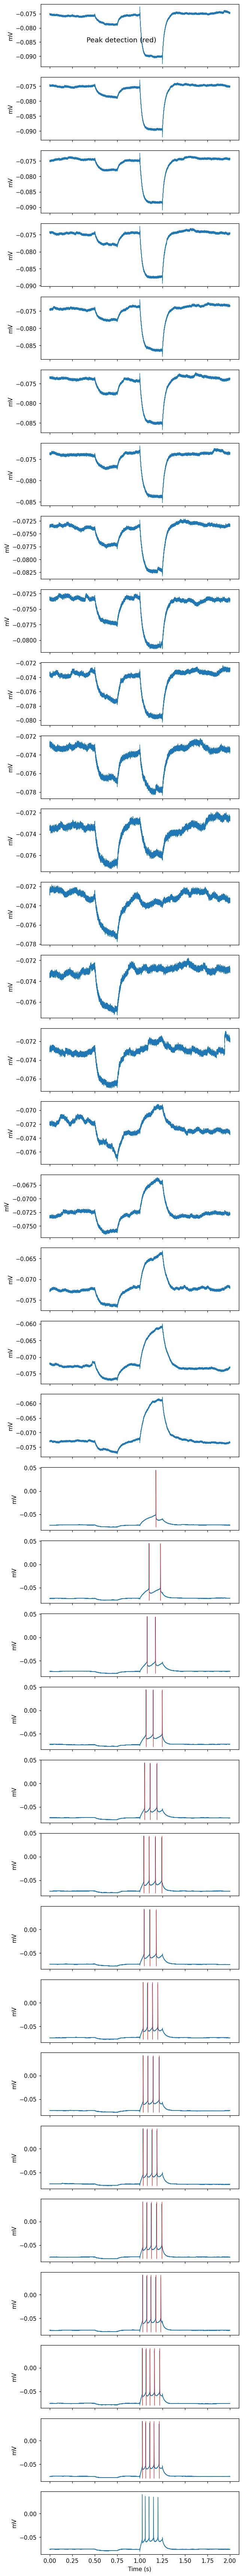

Spikes per sweep: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 2, 3, 3, 4, 3, 4, 4, 4, 5, 5, 5, 5, 0]


In [60]:
# %% 📈  PEAK FINDING  (unit‑aware & more tolerant) ----------------------------
from scipy import signal
import numpy as np

def _to_mV(trace):
    """
    If the trace looks like it's in Volts (|Δ| < 1.0), convert to mV.
    Otherwise assume it's already mV.
    """
    return trace * 1e3 if np.ptp(trace) < 1.0 else trace

peak_locs_by_sweep = []

for sw, (_, _, es, ee) in zip(all_sweeps, pulse_bounds):
    if es is None:
        peak_locs_by_sweep.append(np.array([], dtype=int))
        continue

    seg = _to_mV(sw.response_mV[es:ee])                 # <-- guarantee mV
    sm  = signal.convolve(seg, np.ones(SMOOTH_PTS)/SMOOTH_PTS, mode="same")

    # If user‑set PEAK_PROMINENCE_MV is too strict, auto‑scale down
    prom = min(PEAK_PROMINENCE_MV, 0.4 * np.ptp(seg))   # 40 % of peak‑to‑peak

    peaks, _ = signal.find_peaks(
        sm,
        prominence=prom,
        height   = seg.min() + 0.05 * np.ptp(seg)       # 5 % above baseline
    )
    peak_locs_by_sweep.append(peaks.astype(int) + es)   # -> global idx (int)

# ---------- plot every sweep with red lines -----------------------------------
if not any(len(p) for p in peak_locs_by_sweep):
    print("⚠ No peaks detected – try lowering PEAK_PROMINENCE_MV or SMOOTH_PTS.")
else:
    fig, axs = plt.subplots(len(all_sweeps), 1,
                            figsize=(6, 1.8*len(all_sweeps)), sharex=True)
    for (sw, peaks), ax in zip(zip(all_sweeps, peak_locs_by_sweep), axs):
        ax.plot(sw.time, sw.response_mV, lw=.8)
        if len(peaks):
            ax.vlines(sw.time[peaks], ymin=sw.response_mV.min(),
                      ymax=sw.response_mV.max(), color='red', lw=.7)
        ax.set_ylabel("mV")
    axs[-1].set_xlabel("Time (s)")
    plt.suptitle("Peak detection (red)"); plt.tight_layout(); plt.show()

print("Spikes per sweep:", [len(p) for p in peak_locs_by_sweep])




sweep  current_inj_pA  mean_firing_frequency_Hz
0       1       -0.311692                   0.00000
1       2       -0.286601                   0.00000
2       3       -0.261950                   0.00000
3       4       -0.236829                   0.00000
4       5       -0.211972                   0.00000
5       6       -0.186829                   0.00000
6       7       -0.161953                   0.00000
7       8       -0.136804                   0.00000
8       9       -0.112079                   0.00000
9      10       -0.087422                   0.00000
10     11       -0.062151                   0.00000
11     12       -0.037300                   0.00000
12     13       -0.012006                   0.00000
13     15        0.012793                   0.00000
14     16        0.037933                   0.00000
15     17        0.062703                   0.00000
16     18        0.087795                   0.00000
17     19        0.112684                   0.00000
18     20        0.137930                   0.00000
19     21        0.162821                   3.99998
20     22        0.188060                   7.99996
21     23        0.212808                   7.99996
22     24        0.237459                  11.99994
23     25        0.262478                  11.99994
24     26        0.287467                  15.99992
25     27        0.312722                  11.99994
26     28        0.337493                  15.99992
27     29        0.362748                  15.99992
28     30        0.387514                  15.99992
29     31        0.412633                  19.99990
30     32        0.437405                  19.99990
31     33        0.462643                  19.99990
32     34        0.487518                  19.99990

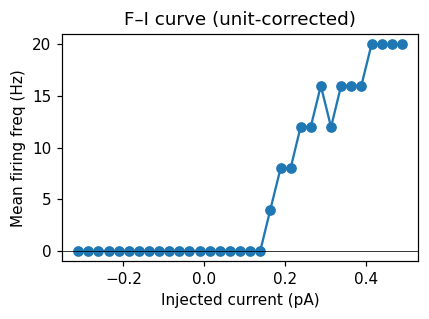

In [61]:
# %% 📊  F–I curve (unit‑safe, keeps sub‑threshold) ----------------------------
fi_rows = []

for sw_idx, ((sw, (ts, te, es, ee)), peaks) in enumerate(
        zip(zip(all_sweeps, pulse_bounds), peak_locs_by_sweep), 1):

    if es is None or ee is None:
        continue   # pulse detection failed → skip sweep entirely

    dt = 1.0 / sw.sample_rate
    stim_len_s = (ee - es) * dt

    # ---------- injected current (auto scale to pA) --------------------------
    steady = sw.command_pA[es + int(0.01/dt) : ee - int(0.01/dt)]
    inj_mean = float(np.mean(steady))
    # If the magnitude is tiny (<1e‑7 A), assume units are A → convert to pA
    if abs(inj_mean) < 1e-7:
        inj_pA = inj_mean * 1e12
    else:
        inj_pA = inj_mean                      # already pA

    # ---------- firing frequency --------------------------------------------
    mean_freq = len(peaks) / stim_len_s if stim_len_s else 0.0

    fi_rows.append(dict(
        sweep                   = sw_idx,
        current_inj_pA          = inj_pA,
        mean_firing_frequency_Hz= mean_freq,
    ))

fi_df = (pd.DataFrame(fi_rows)
           .sort_values("current_inj_pA")
           .reset_index(drop=True))
display(fi_df)

# ---------- plot --------------------------------------------------------------
plt.figure(figsize=(4,3))
plt.plot(fi_df["current_inj_pA"], fi_df["mean_firing_frequency_Hz"],
         marker='o')
plt.axhline(0, color='k', lw=.5)
plt.xlabel("Injected current (pA)")
plt.ylabel("Mean firing freq (Hz)")
plt.title("F–I curve (unit‑corrected)"); plt.tight_layout(); plt.show()



C:\Users\sa-forest\AppData\Local\Temp\ipykernel_38944\1703486494.py:25: PeakPropertyWarning: some peaks have a prominence of 0
  prominences = signal.peak_prominences(rsp_mV, [pk])[0]


sweep  spike_number  current_inj_pA    peak_mV  half_width_ms     AHP_mV  \
0     21             0        0.162821  44.483100       0.110001  11.944288   
1     22             0        0.188060  44.770529       0.120001  11.177810   
2     22             1        0.188060  43.205636       0.120001  11.241683   
3     23             0        0.212808  44.195671       0.120001  11.273620   
4     23             1        0.212808  43.014016       0.110001  11.018127   

   threshold_mV  dvdt_max_mV_per_ms  
0    -47.781737          370.462708  
1    -49.123075          403.995970  
2    -46.855576          370.462708  
3    -49.155011          396.011860  
4    -47.238815          384.834106

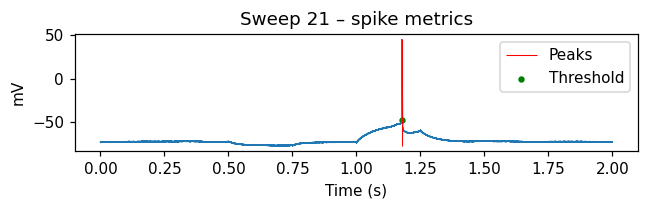

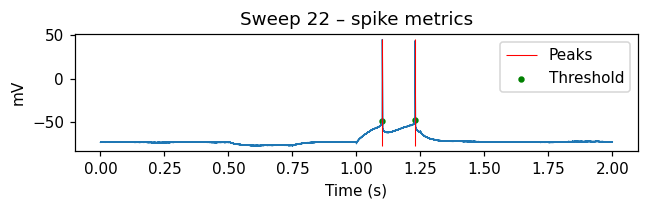

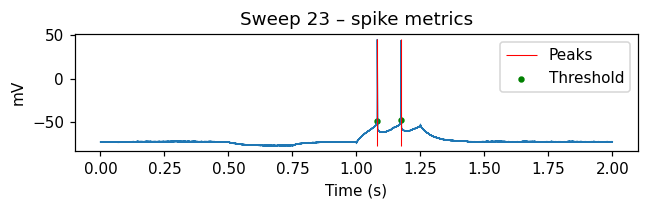

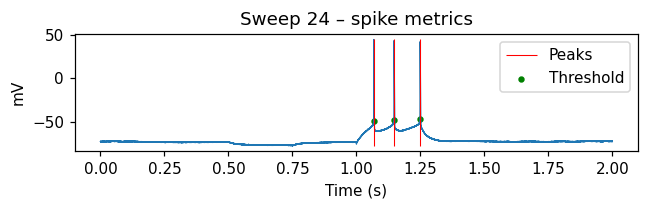

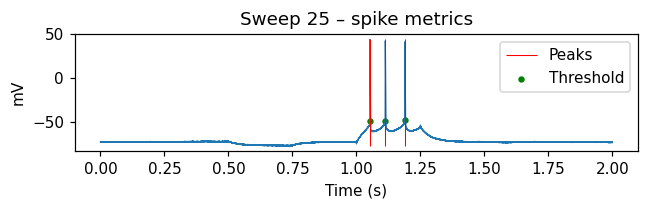

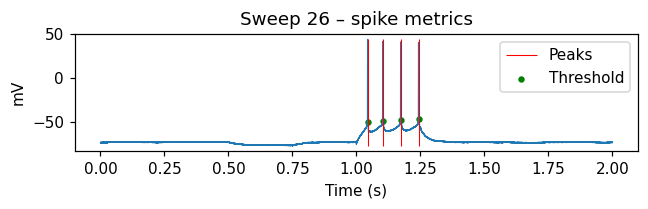

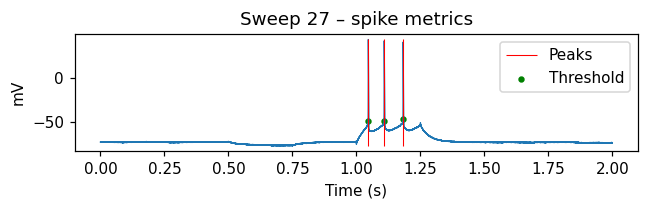

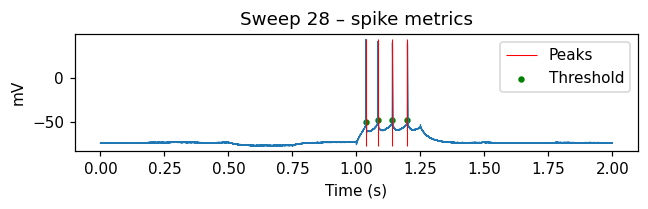

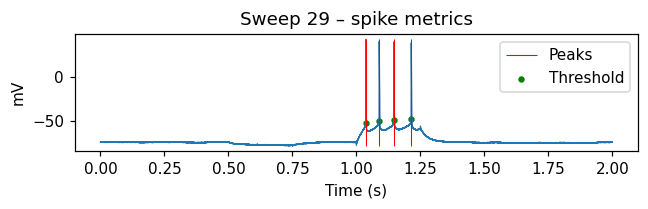

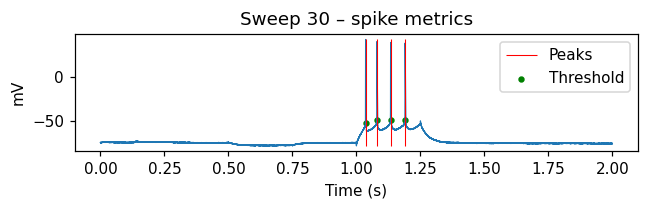

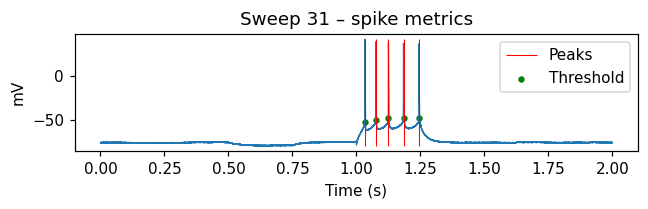

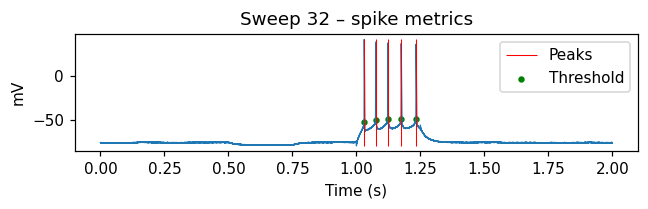

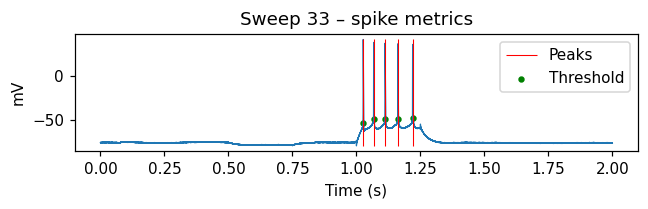

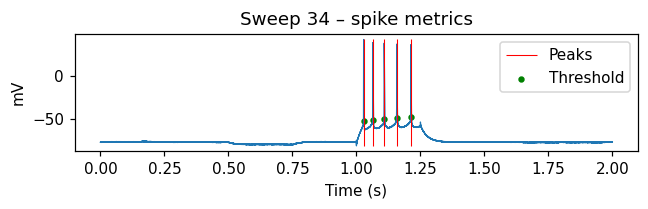

Total spikes analysed: 50


In [62]:
# %% 🧮  Spike‑by‑spike metrics  (pulse_bounds‑based) --------------------------
from scipy import signal
import numpy as np
import pandas as pd

def _to_mV(x):          # ensure units
    return x*1e3 if np.ptp(x) < 1.0 else x

all_rows = []

for sw_idx, (sw, (ts, te, es, ee), peaks) in enumerate(
        zip(all_sweeps, pulse_bounds, peak_locs_by_sweep), 1):

    if es is None or ee is None or len(peaks) == 0:
        continue    # nothing to analyse for this sweep

    rsp_mV = _to_mV(sw.response_mV)
    dt     = 1.0 / sw.sample_rate          # s
    dvdt   = np.gradient(rsp_mV, dt*1e3)   # mV/ms

    for p_num, pk in enumerate(peaks.astype(int)):      # pk = global idx
        win = int(HW_WINDOW_MS / 1000 / dt)             # ±HW_WINDOW_MS

        # ── half‑width
        prominences = signal.peak_prominences(rsp_mV, [pk])[0]
        half_val = rsp_mV[pk] - 0.5 * prominences[0]
        local = rsp_mV[pk-win : pk+win]
        xloc  = np.where(local > half_val)[0]
        if xloc.size < 2:
            continue
        half_w_ms = (xloc[-1] - xloc[0]) * dt * 1e3

        # ── threshold (last dv/dt below threshold before spike)
        dv_seg = dvdt[pk-win : pk-win//10]
        below  = np.where(dv_seg < DVDT_THRESH_MV_MS)[0]
        if below.size == 0:
            continue
        thresh_idx = pk - win + below[-1]
        thresh_mV  = rsp_mV[thresh_idx]

        # ── dv/dt max ±win
        dv_max = dvdt[pk-win : pk+win].max()

        # ── AHP (to +6 ms after peak)
        ahp = abs(rsp_mV[pk : pk + int(0.006/dt)].min() - thresh_mV)

        # ── injected current (auto‑scale to pA)
        steady = sw.command_pA[es + int(0.01/dt) : ee - int(0.01/dt)]
        inj_mean = float(np.mean(steady))
        inj_pA   = inj_mean*1e12 if abs(inj_mean) < 1e-7 else inj_mean

        all_rows.append(dict(
            sweep              = sw_idx,
            spike_number       = p_num,
            current_inj_pA     = inj_pA,
            peak_mV            = rsp_mV[pk],
            half_width_ms      = half_w_ms,
            AHP_mV             = ahp,
            threshold_mV       = thresh_mV,
            dvdt_max_mV_per_ms = dv_max,
        ))

spk_df = pd.DataFrame(all_rows)
display(spk_df.head())

# -------- diagnostic plot for every spike ------------------------------------
for sw_idx, sw in enumerate(all_sweeps, 1):
    one = spk_df[spk_df["sweep"] == sw_idx]
    if one.empty:
        continue
    plt.figure(figsize=(6,2))
    plt.plot(sw.time, _to_mV(sw.response_mV), lw=.8)
    pk_idx = one["spike_number"].values.astype(int)
    pk_glb = peak_locs_by_sweep[sw_idx-1][pk_idx]
    plt.vlines(sw.time[pk_glb], ymin=_to_mV(sw.response_mV).min(),
               ymax=_to_mV(sw.response_mV).max(),
               color='red', lw=.7, label="Peaks")
    plt.scatter(sw.time[pk_glb], one["threshold_mV"],
                c='green', s=10, label="Threshold")
    plt.ylabel("mV"); plt.xlabel("Time (s)")
    plt.title(f"Sweep {sw_idx} – spike metrics"); plt.legend()
    plt.tight_layout(); plt.show()

print(f"Total spikes analysed: {len(spk_df)}")



In [63]:
# %% 🗒️  SUMMARY TABLES  --------------------------------------------------------
print("F–I table:")
display(fi_df)

print("\nSpike‑metrics table:")
display(spk_df)

print(f"\nTotal spikes analysed: {len(spk_df)}")


F–I table:


sweep  current_inj_pA  mean_firing_frequency_Hz
0       1       -0.311692                   0.00000
1       2       -0.286601                   0.00000
2       3       -0.261950                   0.00000
3       4       -0.236829                   0.00000
4       5       -0.211972                   0.00000
5       6       -0.186829                   0.00000
6       7       -0.161953                   0.00000
7       8       -0.136804                   0.00000
8       9       -0.112079                   0.00000
9      10       -0.087422                   0.00000
10     11       -0.062151                   0.00000
11     12       -0.037300                   0.00000
12     13       -0.012006                   0.00000
13     15        0.012793                   0.00000
14     16        0.037933                   0.00000
15     17        0.062703                   0.00000
16     18        0.087795                   0.00000
17     19        0.112684                   0.00000
18     20        0.137930                   0.00000
19     21        0.162821                   3.99998
20     22        0.188060                   7.99996
21     23        0.212808                   7.99996
22     24        0.237459                  11.99994
23     25        0.262478                  11.99994
24     26        0.287467                  15.99992
25     27        0.312722                  11.99994
26     28        0.337493                  15.99992
27     29        0.362748                  15.99992
28     30        0.387514                  15.99992
29     31        0.412633                  19.99990
30     32        0.437405                  19.99990
31     33        0.462643                  19.99990
32     34        0.487518                  19.99990


Spike‑metrics table:


sweep  spike_number  current_inj_pA    peak_mV  half_width_ms     AHP_mV  \
0      21             0        0.162821  44.483100       0.110001  11.944288   
1      22             0        0.188060  44.770529       0.120001  11.177810   
2      22             1        0.188060  43.205636       0.120001  11.241683   
3      23             0        0.212808  44.195671       0.120001  11.273620   
4      23             1        0.212808  43.014016       0.110001  11.018127   
5      24             0        0.237459  43.908241       0.110001  11.209747   
6      24             1        0.237459  42.758524       0.120001  10.315522   
7      24             2        0.237459  41.672679       0.110001  10.666824   
8      25             0        0.262478  43.620812       0.120001  11.209747   
9      25             1        0.262478  41.928172       0.120001   9.868409   
10     25             2        0.262478  40.938137       0.110001   9.421297   
11     26             0        0.287467  43.556939       0.110001  10.507141   
12     26             1        0.287467  41.257503       0.130001   9.612917   
13     26             2        0.287467  40.938137       0.100001   9.229677   
14     26             3        0.287467  39.948103       0.110001  10.060029   
15     27             0        0.312722  42.694650       0.110001  11.401366   
16     27             1        0.312722  41.161694       0.100001   8.910311   
17     27             2        0.312722  39.788420       0.120001   9.644853   
18     28             0        0.337493  42.407221       0.130001  10.634888   
19     28             1        0.337493  40.491025       0.110001   9.644853   
20     28             2        0.337493  39.245498       0.130001   8.910311   
21     28             3        0.337493  38.606766       0.130001   8.271579   
22     29             0        0.362748  42.055918       0.130001   9.676790   
23     29             1        0.362748  40.075849       0.130001   8.463199   
24     29             2        0.362748  39.373244       0.130001   9.069994   
25     29             3        0.362748  38.702575       0.100001   9.101931   
26     30             0        0.387514  41.928172       0.120001  10.187775   
27     30             1        0.387514  39.309371       0.120001  10.347458   
28     30             2        0.387514  38.415146       0.130001   8.718692   
29     30             3        0.387514  37.616731       0.130001   7.984150   
30     31             0        0.412633  41.481060       0.110001   9.261614   
31     31             1        0.412633  38.926132       0.130001   9.485170   
32     31             2        0.412633  37.936097       0.100001   9.485170   
33     31             3        0.412633  37.233492       0.120001   8.942248   
34     31             4        0.412633  36.722506       0.140001  10.666824   
35     32             0        0.437405  41.353313       0.120001  10.411332   
36     32             1        0.437405  38.574829       0.110001   9.453234   
37     32             2        0.437405  36.914126       0.130001   8.431262   
38     32             3        0.437405  36.722506       0.130001   8.399326   
39     32             4        0.437405  36.275394       0.130001   7.952213   
40     33             0        0.462643  40.778454       0.130001   9.517107   
41     33             1        0.462643  37.872224       0.100001   9.868409   
42     33             2        0.462643  36.754443       0.110001   8.399326   
43     33             3        0.462643  36.211521       0.110001   7.281545   
44     33             4        0.462643  35.540852       0.100001   8.463199   
45     34             0        0.487518  40.331342       0.120001   9.900346   
46     34             1        0.487518  37.201555       0.120001   8.942248   
47     34             2        0.487518  36.498950       0.110001   7.600911   
48     34             3        0.487518  35.317296       0.130001   8.016087   
49  


Total spikes analysed: 50


Normalising F–I by Cm = 598.1 pF from passive fits


sweep  current_inj_pA  mean_firing_frequency_Hz  NormFreq_Hz_per_(pA/Cm)
0       1       -0.311692                   0.00000                -0.000000
1       2       -0.286601                   0.00000                -0.000000
2       3       -0.261950                   0.00000                -0.000000
3       4       -0.236829                   0.00000                -0.000000
4       5       -0.211972                   0.00000                -0.000000
5       6       -0.186829                   0.00000                -0.000000
6       7       -0.161953                   0.00000                -0.000000
7       8       -0.136804                   0.00000                -0.000000
8       9       -0.112079                   0.00000                -0.000000
9      10       -0.087422                   0.00000                -0.000000
10     11       -0.062151                   0.00000                -0.000000
11     12       -0.037300                   0.00000                -0.000000
12     13       -0.012006                   0.00000                -0.000000
13     15        0.012793                   0.00000                 0.000000
14     16        0.037933                   0.00000                 0.000000
15     17        0.062703                   0.00000                 0.000000
16     18        0.087795                   0.00000                 0.000000
17     19        0.112684                   0.00000                 0.000000
18     20        0.137930                   0.00000                 0.000000
19     21        0.162821                   3.99998             14692.476491
20     22        0.188060                   7.99996             25441.301543
21     23        0.212808                   7.99996             22482.653409
22     24        0.237459                  11.99994             30223.029162
23     25        0.262478                  11.99994             27342.220401
24     26        0.287467                  15.99992             33287.298206
25     27        0.312722                  11.99994             22949.272179
26     28        0.337493                  15.99992             28353.151942
27     29        0.362748                  15.99992             26379.141595
28     30        0.387514                  15.99992             24693.263746
29     31        0.412633                  19.99990             28987.568279
30     32        0.437405                  19.99990             27345.931096
31     33        0.462643                  19.99990             25854.167488
32     34        0.487518                  19.99990             24534.981488

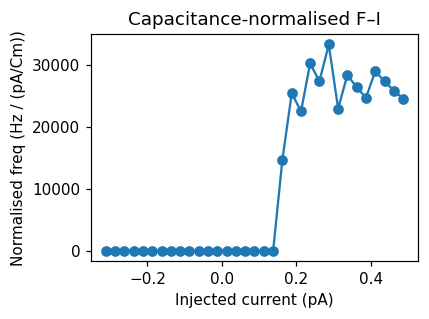

In [65]:
# %% ⚖️  NORMALISATION (optional)  ---------------------------------------------
if DO_NORMALISE and not fi_df.empty:
    # Need Cm_pF – use mean from passive summary of THIS cell (already in res_df)
    if "Cm_pF" in locals() and not np.isnan(Cm_pF):
        print(f"Normalising F–I by Cm = {Cm_pF:.1f} pF from passive fits")
        Cm_val = Cm_pF
    else:
        raise RuntimeError("Cm_pF not defined – compute passives first.")
    fi_df["NormFreq_Hz_per_(pA/Cm)"] = fi_df["mean_firing_frequency_Hz"] * Cm_val / fi_df["current_inj_pA"]
    display(fi_df)

    plt.figure(figsize=(4,3))
    plt.plot(fi_df["current_inj_pA"], fi_df["NormFreq_Hz_per_(pA/Cm)"],
             marker='o')
    plt.xlabel("Injected current (pA)")
    plt.ylabel("Normalised freq (Hz / (pA/Cm))")
    plt.title("Capacitance‑normalised F–I"); plt.tight_layout(); plt.show()
else:
    print("Normalisation skipped (set DO_NORMALISE=True to enable).")
